In [1]:
import os
import time
import numpy as np
import pandas as pd
from PIL import Image, ImageOps

import tensorflow as tf
from tensorflow.python import profiler 

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.layers import TimeDistributed, Conv2D, LSTM, Dropout, Flatten, Dense, Input, MaxPooling3D, MaxPooling2D, Conv3D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.models import load_model, Model, Sequential

In [2]:
FRAME_RATE = 2

IMG_HEIGHT = 50
IMG_WIDTH = 120
IMG_DEPTH_DIM = 1

INPUT_SHAPE = (FRAME_RATE, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH_DIM)

In [3]:
def printTotalFlops(modelPath):
    tf.compat.v1.reset_default_graph()
    
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = load_model(modelPath)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            print("Total Flops:", flops.total_float_ops)

In [4]:
train_paths = []

def readFolderStructure(train_folders):
    train_paths = []
    for dirname, _, filenames in os.walk('/kaggle/input/markku-large/'):
        if os.path.basename(dirname) in train_folders:
            for sub_dir in os.listdir(dirname):
                train_paths.append(dirname + '/' + sub_dir)
    print(train_paths)
    return train_paths

print('Done')

Done


In [5]:
from keras.preprocessing.image import load_img, img_to_array
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

def readDataFromSubFolders(train_paths):
    data = pd.DataFrame()

    for path in train_paths:
        sub_data = pd.read_csv(path + '/data-set.csv')
        sub_data['file path'] = sub_data['file path'].apply(lambda x: path + '/' + x)
        data = data.append(sub_data)

    return data

print('Done')

Done


Using TensorFlow backend.


In [6]:
def extractXandY(data, verbose=True):
    X = []
    X_reverse = []
    y = []
    y_reverse = []

    for index, row in data.iterrows():
        img = Image.open(row['file path'])
        img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        if IMG_DEPTH_DIM == 1:
            img = ImageOps.grayscale(img)
            X.append(np.expand_dims(np.array(img), axis=2))
        else:
            X.append(np.array(img))
        y.append([row['throttle'], row['angle']])

        X_reverse.append(np.flip(X[-1],1))
        y_reverse.append([row['throttle'], row['angle'] * -1])

    X = np.concatenate((X, X_reverse), axis=0)
    y = np.concatenate((y, y_reverse), axis=0)
    
    if verbose:
        if IMG_DEPTH_DIM == 1:
            plt.imshow(np.squeeze(X[0], axis=2), cmap='gray', vmin=0, vmax=255)
            plt.show()
            plt.imshow(np.squeeze(X_reverse[0], axis=2), cmap='gray', vmin=0, vmax=255)
            plt.show()
        else:
            plt.imshow(X[0])
            plt.show()
            plt.imshow(X_reverse[0])
            plt.show()

        sns.lineplot(data=y.T[0]).set_title("Expected Throttle")
        plt.show()
        sns.lineplot(data=y.T[1]).set_title("Expected Angle")
        plt.show()

    print("Loaded ", len(X), " data points")
    return (X,y)

print('Done')

Done


In [7]:
def mapIntoFrames(X,y,skip_frames=0):
    batch_list = []
    expected_result = []
    skip_frames += 1
    
    rangeEnd = min(len(X), len(y)) - FRAME_RATE * skip_frames + 1

    for i in range(0, rangeEnd):
        frameBuffer = []
        for frameIdx in range(0, FRAME_RATE*skip_frames, skip_frames):
            frameBuffer.append(X[i+frameIdx])
                       
        batch_list.append(frameBuffer)
        expected_result.append(y[i+FRAME_RATE+skip_frames-2])

    X_frames = np.array(batch_list)
    y_frames = np.array(expected_result)
    return (X_frames,y_frames)

print('Done')

mapIntoFrames([1,2,3,4,5,6,7,8],[1,2,3,4,5,6,7,8])

Done


(array([[1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 8]]), array([2, 3, 4, 5, 6, 7, 8]))

In [8]:
import numpy as np
import cv2

def createVideo(X, y, model, video_filename="track-video.avi", rolling_mean=None, skip_frames=0):
    if model is None:
        print("Creating video using reference (y)...")
    else:
        print("Creating video using model...")

    if rolling_mean is not None:
        y = pd.DataFrame(data=y).rolling(rolling_mean, min_periods=1).mean().to_numpy()

    X_frames, y_frames = mapIntoFrames(X,y, skip_frames=skip_frames)

    height = 500
    width = 700
    water_depth = np.zeros((height, width), dtype=float)

    # initialize video writer
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    fps = 15

    isColor = IMG_DEPTH_DIM > 1
    out = cv2.VideoWriter(video_filename, fourcc, fps, (120, 50), isColor)

    for i in range(0, len(X_frames)):
        frame = X_frames[i][FRAME_RATE-1].copy()
        
        angle = y[i][1]
        throttle = y[i][0]

        if model is not None:
            angle, throttle = model.predict(np.expand_dims(X_frames[i], axis=0))
            angle = angle[0][0]
            throttle = throttle[0][0]
        
        throttle_height = int(min(40, max(2, throttle * 60)))
        angle_offset = min(110, max(10, int(60 + (angle * 50))))

        for a in range(10):
            frame[a][60][0] = 0
            frame[a][10][0] = 0
            frame[a][110][0] = 0
        
        for a in range(throttle_height):
            for b in range(6):
                frame[a][angle_offset+b-3][0] = 0
                
                if IMG_DEPTH_DIM == 3:
                    frame[a][angle_offset+b-3][1] = 0
                    frame[a][angle_offset+b-3][2] = 255

        out.write(frame)
    out.release()
    print("Video creation done")

print('Done')

Done


In [9]:
def preprocessImages(X):
    preprocessed = []

    for img_array in X:
        img_array_expanded_dims = np.expand_dims(img_array, axis=0)
        preprocessed.append(preprocess_input(img_array_expanded_dims)[0])
    return np.array(preprocessed)

print('Done')

Done


# Convolutional LSTM

In [10]:
def buildLstm():
    
    cnnModel = Sequential()
    cnnModel.add(Conv2D(16, (3, 3), data_format='channels_last'))
    cnnModel.add(Conv2D(16, (3, 3)))
    cnnModel.add(Conv2D(32, (5, 5), strides=2))
    cnnModel.add(MaxPooling2D(pool_size=(3,3), padding='valid'))
    cnnModel.add(Dense(120, activation='linear'))
    cnnModel.add(Dense(60, activation='linear'))
    cnnModel.add(Flatten())

    inputLayer = Input(shape=INPUT_SHAPE, name='input_layer')
    serial = inputLayer
    serial = TimeDistributed(cnnModel, input_shape=INPUT_SHAPE)(serial)
    serial = LSTM(20, dropout=0.2, recurrent_dropout=0.2)(serial)
    serial = Flatten()(serial)
    
    angle_out = Dense(units=1, activation='linear', name='angle_out')(serial)
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(serial)
    
    lstmModel = Model(inputs=[inputLayer], outputs=[angle_out, throttle_out])
    lstmModel.compile(optimizer='adam',
                      loss={'angle_out': 'mean_squared_error', 'throttle_out': 'mean_squared_error'},
                      loss_weights={'angle_out': 1.5, 'throttle_out': 1})
    
    print(cnnModel.summary())
    print(lstmModel.summary())
    return lstmModel

print('Done')

Done


In [11]:
def fitLstmModel(model, X, y, skip_frames=0):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01),
        ModelCheckpoint(filepath='best_lstm_model.h5', monitor='val_loss', save_best_only=True)
    ]
       
    X_pre_processed = preprocessImages(X)
    X_frames, y_frames = mapIntoFrames(X_pre_processed,y, skip_frames)
    
    throttle = y_frames.T[0]
    angle = y_frames.T[1]
        
    model.fit(X_frames, {'angle_out': angle, 'throttle_out': throttle}, batch_size=20, epochs=20, validation_split=0.2, shuffle=True, callbacks=callbacks)
    return model

print('Done')

Done


In [12]:
def checkModel(model, data, X, y, rangeStart = 0, rangeEnd = 300):
    startTime = int(round(time.time() * 1000))

    X_frames, y_frames = mapIntoFrames(X,y)
    angle, throttle = model.predict(X_frames)
    
    endTime = int(round(time.time() * 1000))
    print("Total Prediction Time:", (endTime - startTime) / 1000)
    
    sns.lineplot(data=data.throttle[rangeStart:rangeEnd]).set_title("Actual Throttle")
    plt.show()
    sns.lineplot(data=throttle[rangeStart:rangeEnd]).set_title("Predicted Throttle")
    plt.show()
    
    sns.lineplot(data=data.angle[rangeStart:rangeEnd]).set_title("Actual Angle")
    plt.show()
    sns.lineplot(data=angle[rangeStart:rangeEnd]).set_title("Predicted Angle")
    plt.show()

print('Done')

Done


In [13]:
# train_paths = readFolderStructure(['aalto', 'MPD-test'])

# data = readDataFromSubFolders(train_paths)
# X,y = extractXandY(data)

# # creates a reference video based on X and y
# createVideo(X[:2000],y[:2000], None,"reference-video.avi")

# lstmModel = buildLstm()
# lstmModel = fitLstmModel(lstmModel, X, y)

# loadedModel = load_model('/kaggle/working/best_lstm_model.h5')
# fitLstmModel(loadedModel, X, y)

# checkModel(loadedModel, data, X, y)
# createVideo(X[:600],y[:600], loadedModel, "lstm-video.avi")

# Markku Check

['/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-54-43', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-36-06', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-33-00', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-39-56', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-59-16', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-40-50', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-56-21', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-03-13', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-58-06']


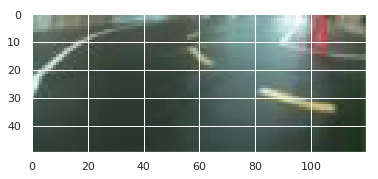

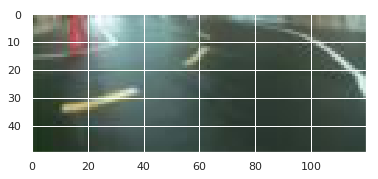

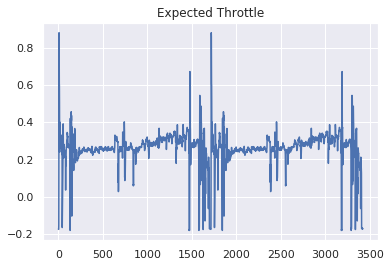

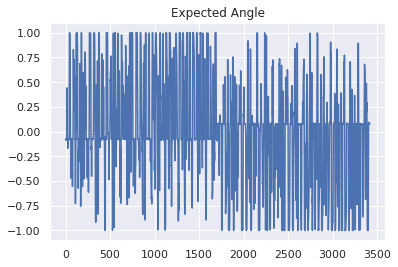

Loaded  3420  data points
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 2, 50, 120,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 2, 17, 40, 24 5424        img_in[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 1, 8, 20, 24) 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 1, 8, 20, 32) 57632       max_pooling3d[0][0]              
____________________________________________________________________

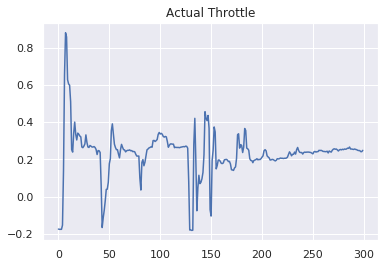

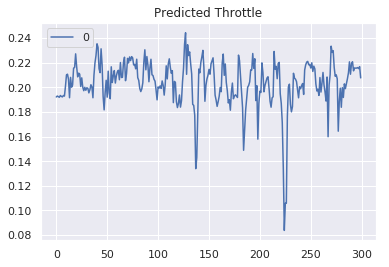

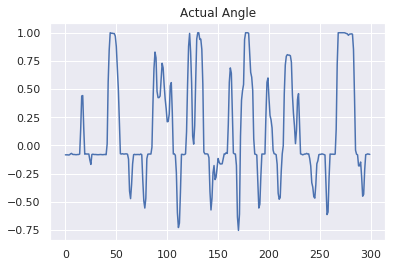

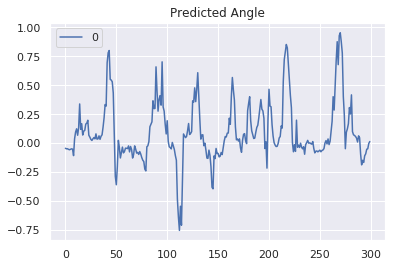

Creating video using model...
Video creation done


In [14]:
IMG_DEPTH_DIM = 3

train_paths = readFolderStructure(['aalto'])
data = readDataFromSubFolders([train_paths[0]])
X,y = extractXandY(data)

markku_model = load_model('/kaggle/input/markku-model/meetup_3_skipflip_1')
print(markku_model.summary())

checkModel(markku_model, data, X, y)
createVideo(X[:600], y[:600], markku_model, "markku-video.avi", skip_frames=0)

# Step By Step

['/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-54-43', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-36-06', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-33-00', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-39-56', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-59-16', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-06-40-50', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-56-21', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-03-13', '/kaggle/input/markku-large/kaggle-dataset/aalto/tub_19-08-22-07-58-06']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  160       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  232

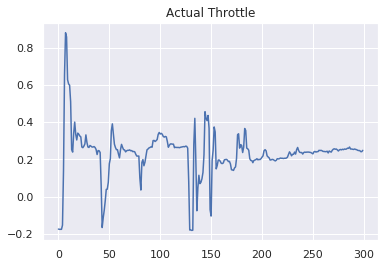

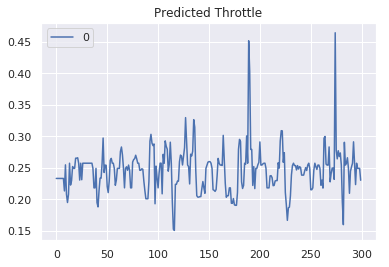

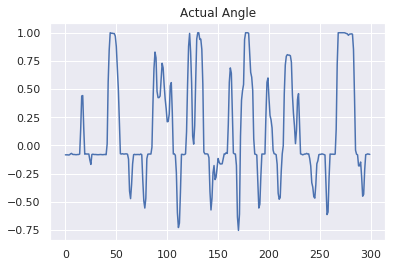

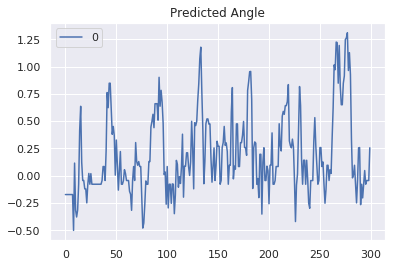

Creating video using model...
Video creation done


In [15]:
IMG_DEPTH_DIM = 1

train_paths = readFolderStructure(['MPD-test', 'aalto'])
lstmModel = buildLstm()

# train
for folder in train_paths:
    print("Loading data from ", folder)
    data = readDataFromSubFolders([folder])
    
    X,y = extractXandY(data, verbose=False)
    # use all frames for training
    lstmModel = fitLstmModel(lstmModel, X, y, skip_frames=0)

# validate
data = readDataFromSubFolders([train_paths[0]])  
X,y = extractXandY(data, verbose=False)

# reference
createVideo(X[:600], y[:600], None, "reference-video.avi")

# model
checkModel(lstmModel, data, X, y)
createVideo(X[:600], y[:600], lstmModel, "lstm-video.avi", skip_frames=0)

In [16]:
print("Markku:")
printTotalFlops('/kaggle/input/markku-model/meetup_3_skipflip_1')

print("LSTM:")
printTotalFlops('/kaggle/working/best_lstm_model.h5')

Markku:
Total Flops: 758819
LSTM:
Total Flops: 1268688


In [17]:
folders = [train_paths[0]]

def measurePerformance(model_path, folders, max_predictions=100):
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    
    data = readDataFromSubFolders(folders)  
    X,y = extractXandY(data, verbose=False)
    X_frames, y_frames = mapIntoFrames(X, y)
    
    model = load_model(model_path)
    
    startTime = time.time()  

    for i in range(len(X_frames[:max_predictions])):
        model.predict(np.array([X_frames[i]]))  
        
    endTime = time.time()
    total = endTime - startTime
    
    print("Total Prediction Time:", round(total, 3), "seconds")
    return total

In [18]:
IMG_DEPTH_DIM = 1

print("LSTM Performance:")
lstm_perf = measurePerformance("/kaggle/working/best_lstm_model.h5", folders)

IMG_DEPTH_DIM = 3
print("\nMarkku Performance:")
markku_perf = measurePerformance("/kaggle/input/markku-model/meetup_3_skipflip_1", folders)

perf_percentage = (100 * lstm_perf) / markku_perf

if perf_percentage < 100:
    print("\nYour network is", round(100 - perf_percentage, 2), "% FASTER than the reference markku network")
else:
    print("\nYour network is", round(perf_percentage - 100, 2), "% SLOWER than the reference markku network")

LSTM Performance:
Loaded  3420  data points
Total Prediction Time: 3.215 seconds

Markku Performance:
Loaded  3420  data points
Total Prediction Time: 2.582 seconds

Your network is 24.53 % SLOWER than the reference markku network
